<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Multivariate_TimeSeries_Weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install autokeras

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak

In [3]:
df = pd.read_csv('https://github.com/hamaadshah/hackathon_june_2018/raw/master/jena_climate_2009_2016.csv')
df

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


# Preprocessing

In [6]:
# 觀察rh(%)對各參數的相關係數,越近1越相關(正or負),越近0越無關
# 可觀察到風速影響很小,因此判斷可忽略,並減少參數量
df.corr()['rh (%)']

p (mbar)          -0.018352
T (degC)          -0.572416
Tpot (K)          -0.567127
Tdew (degC)       -0.156615
rh (%)             1.000000
VPmax (mbar)      -0.615842
VPact (mbar)      -0.151494
VPdef (mbar)      -0.843835
sh (g/kg)         -0.150841
H2OC (mmol/mol)   -0.150969
rho (g/m**3)       0.514282
wv (m/s)          -0.005020
max. wv (m/s)     -0.009921
wd (deg)          -0.015912
Name: rh (%), dtype: float64

In [7]:
# 減少資料量
df = df[5::6] # 原先每10分鐘計一筆,現在只取整點資料,即間隔6筆資料取一次 
df = df.drop(
    ['Date Time', 'wv (m/s)',
     'max. wv (m/s)', 'wd (deg)'], axis=1)
# 檢查DataFrame欄位資料的數量與類別
# 共10類,70091筆,無任何缺失值,另外使用autokeras的時間序列類別時,必須確保傳入的資料為浮點數
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p (mbar)         70091 non-null  float64
 1   T (degC)         70091 non-null  float64
 2   Tpot (K)         70091 non-null  float64
 3   Tdew (degC)      70091 non-null  float64
 4   rh (%)           70091 non-null  float64
 5   VPmax (mbar)     70091 non-null  float64
 6   VPact (mbar)     70091 non-null  float64
 7   VPdef (mbar)     70091 non-null  float64
 8   sh (g/kg)        70091 non-null  float64
 9   H2OC (mmol/mol)  70091 non-null  float64
 10  rho (g/m**3)     70091 non-null  float64
dtypes: float64(11)
memory usage: 5.9 MB


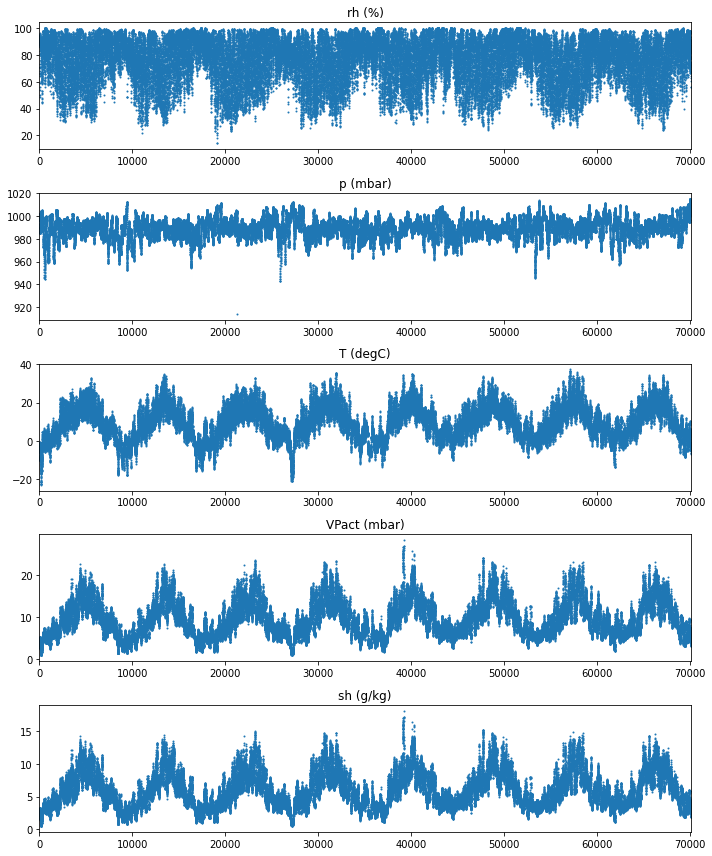

In [8]:
fig = plt.figure(figsize=(10, 12))

names = ('rh (%)', 'p (mbar)', 'T (degC)', 'VPact (mbar)', 'sh (g/kg)')

for i in range(5):
    data = df[names[i]]
    ax = fig.add_subplot(5, 1, i + 1)
    plt.scatter(np.arange(data.size), data, s=1)
    ax.set_xlim([0, data.size])
    ax.set_title(names[i])

plt.tight_layout()
plt.show()

In [9]:
split = 0.125 # 1/8, 前7年訓練,最後1年測試

x = df.drop(['rh (%)'], axis=1)
y = df['rh (%)'] / 100 # target rescale以利快速收斂

slice_index = int(y.size * (1 - split))
x_train, x_test = x[:slice_index], x[slice_index:]
y_train, y_test = y[:slice_index], y[slice_index:]

print(x_train.shape)
print(x_test.shape)

(61329, 10)
(8762, 10)


# Model Training

In [12]:
lookback = 720 # 訓練時回顧前30天歷史, 24hr x 30day = 720hr
batch_size = 72
epochs = 20

reg = ak.TimeseriesForecaster(
    lookback=lookback, max_trials=3, overwrite=True)

reg.fit(
    x_train, y_train, batch_size=batch_size, epochs=epochs,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 3 Complete [01h 45m 12s]
val_loss: 0.014850054867565632

Best val_loss So Far: 0.010891114361584187
Total elapsed time: 03h 53m 59s
INFO:tensorflow:Oracle triggered exit
Epoch 1/20
833/833 [==============================] - 352s 418ms/step - loss: 0.0555 - mean_squared_error: 0.0555
Epoch 2/20
833/833 [==============================] - 350s 420ms/step - loss: 0.0144 - mean_squared_error: 0.0144
Epoch 3/20
833/833 [==============================] - 345s 414ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 4/20
833/833 [==============================] - 350s 421ms/step - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 5/20
833/833 [==============================] - 352s 423ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 6/20
833/833 [==============================] - 352s 423ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 7/20
833/833 [==============================] - 349s 419ms/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 8/20
833/833 [======

INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


INFO:tensorflow:Assets written to: ./time_series_forecaster/best_model/assets


In [14]:
predicted = reg.predict(x).flatten() * 100 #預測時必須要吃原輸入
real = y_test[lookback:] * 100
predicted.size # 預測值比原先x_test少(lookback)個值,表示預測時一樣會先拿一部分測試集作預測,故real部分要修正才能對照

964/964 [==============================] - 180s 186ms/step


8042

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Prediction MSE:', mean_squared_error(real, predicted).round(3))
print('Prediction MAE:', mean_absolute_error(real, predicted).round(3))

Prediction MSE: 84.121
Prediction MAE: 7.434


# Visualization

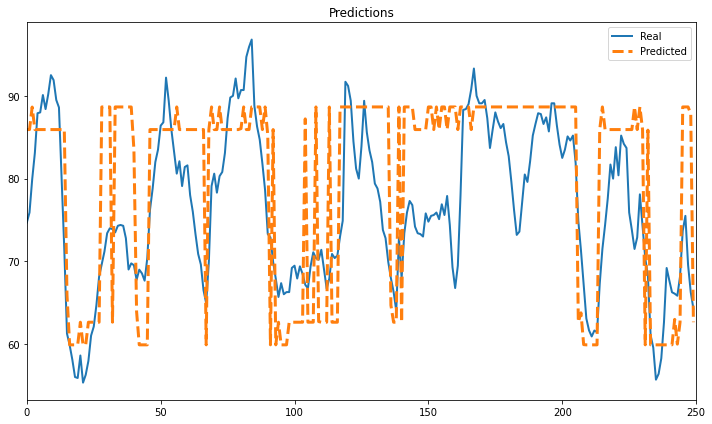

In [16]:
display_size = 250

dx = np.arange(predicted.size)

plt.figure(figsize=(10, 6))
plt.title('Predictions')
plt.plot(dx[:display_size], real[:display_size],
         linewidth=2, label='Real')
plt.plot(dx[:display_size], predicted[:display_size],
         linestyle='--', linewidth=3, label='Predicted')
plt.xlim([0, display_size])
plt.legend()
plt.tight_layout()
plt.show()

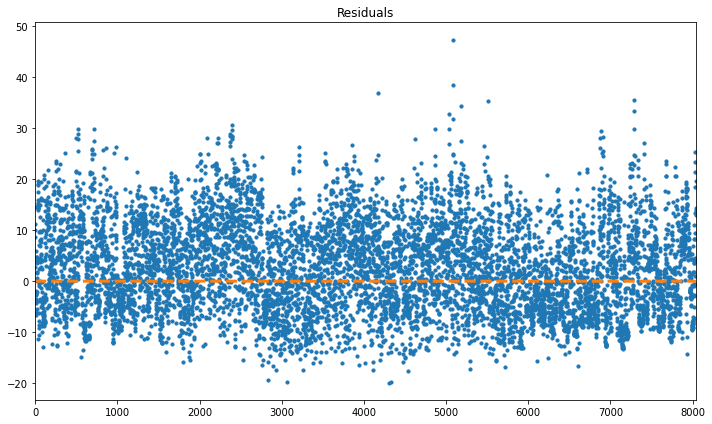

In [17]:
# residuals
residuals = predicted - real.to_numpy()

plt.figure(figsize=(10, 6))
plt.title('Residuals')
plt.scatter(dx, residuals, s=10)
plt.plot(dx, dx*0, linestyle='--', linewidth=3,
         color='tab:orange')
plt.xlim([0, dx.size])
plt.tight_layout()
plt.show()

In [18]:
model = reg.export_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 10)]         0         
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1680      
 l)                                                              
                                                                 
 regression_head_1 (Dense)   (None, 1)                 21        
                                                                 
Total params: 1,701
Trainable params: 1,701
Non-trainable params: 0
_________________________________________________________________


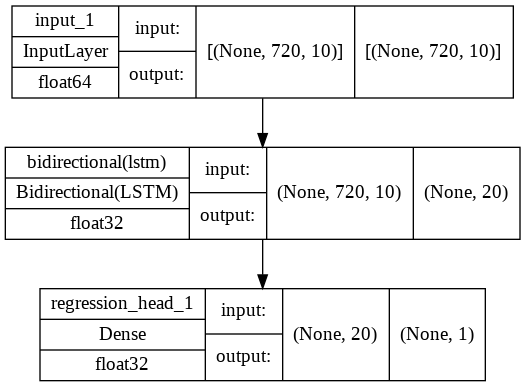

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_dtype=True)

# Load model

In [20]:
from tensorflow.keras.models import load_model
loaded_model = load_model('./time_series_forecaster/best_model', custom_objects=ak.CUSTOM_OBJECTS)

In [21]:
new_test = x_test[-lookback:].to_numpy()
new_test = np.reshape(new_test, (1, lookback, new_test.shape[1]))
print('input:', new_test.shape)

input: (1, 720, 10)


In [22]:
# 取得最末端720筆資料,並用來預測新一個濕度值(y_test的下一筆,原資料沒有的)

# 取測試集最末720筆資料,並將之轉為ndarray
new_test = x_test[-lookback:].to_numpy()

# 預測新的相對值
new_predicted = loaded_model.predict(new_test).flatten()*100

# error, 因為匯入模型已轉為keras模型,透過前面model.summary可知輸入形狀已改變,變成(None,720,10),
# 因此每批輸入必須包含720個連續資料,每筆資料有10特徵,故需將目前的資料(720,10)增加維度(1,720,10)

ValueError: ignored

In [23]:
# 取得最末端720筆資料,並用來預測新一個濕度值(y_test的下一筆,原資料沒有的)
new_test = x_test[-lookback:].to_numpy()
# 增加一個維度
new_test = np.reshape(new_test, (1, lookback, new_test.shape[1]))
print('input:', new_test.shape)

new_predicted = loaded_model.predict(new_test).flatten() * 100
print('predicted:', new_predicted) 

# 預測值陣列只會有1個元素,若想預測新的30筆值,則輸入資料形狀需(30,720,10)

input: (1, 720, 10)
predicted: [85.92517]


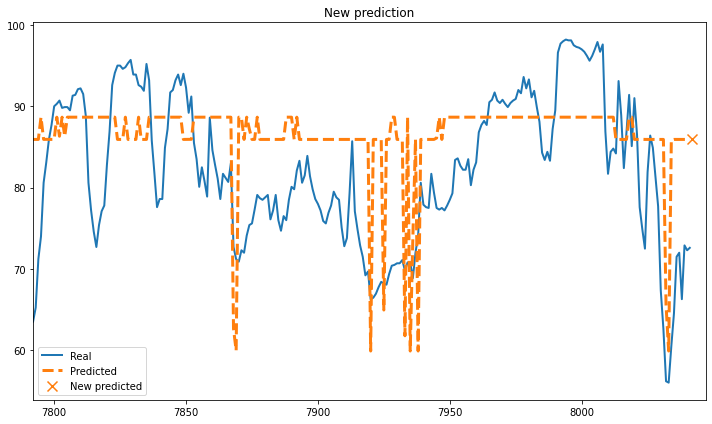

In [24]:
display_size = 250

dx = np.arange(predicted.size)

plt.figure(figsize=(10, 6))
plt.title('New prediction')

# 真實值曲線
plt.plot(dx[-display_size:], real[-display_size:],
         linewidth=2, label='Real')
# 預測值曲線
plt.plot(dx[-display_size:], predicted[-display_size:],
         linestyle='--',  linewidth=3, label='Predicted')
# 新一筆預測值(不會有真實值對應!)
plt.scatter(dx[-1]+1, new_predicted[0],
            s=100, marker='x', color='tab:orange', 
            label='New predicted')
plt.xlim([dx.size-display_size, dx.size+5])
plt.legend()
plt.tight_layout()
plt.show()